# **Word GRU Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla GRU** for word-level language modeling.


### **What We'll Build:**
- **Vanilla GRU** with two (update, reset) gates
- **Backpropagation** for gradient computation
- **Word-level text generation** from learned patterns
---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [1]:
import re
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [2]:
data = open('../data/thirsty_crow.txt', 'r').read()
words = re.findall(r"\w+|[.,!?'\";:]", data.lower())
SOS_TOKEN = '<SOS>'  # Start of Sequence
EOS_TOKEN = '<EOS>'  # End of Sequence
UNK_TOKEN = '<UNK>'  # Unknown word
vocab = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(list(set(words)))
data_size, vocab_size = len(words), len(vocab)
print(f'Data has {data_size} words, {vocab_size} unique (including special tokens).')
print(f'Special tokens: {vocab[:3]}')
print(f'Sample words: {vocab[3:13]}')

Data has 148 words, 90 unique (including special tokens).
Special tokens: ['<SOS>', '<EOS>', '<UNK>']
Sample words: ['!', ',', '.', 'a', 'after', 'an', 'and', 'at', 'away', 'beak']


In [3]:
word_to_ix = {w: i for i, w in enumerate(vocab)}

In [4]:
ix_to_word = {i: w for i, w in enumerate(vocab)}

### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3 # learning rate
seq_len = 25 # times GRU will be unrolled (Timesteps)
hidden_size = 100 # size of hidden units
embed_size = 100 # size of word embedding vector

### __MODEL PARAM INIT__
**Initializing weight matrices for the GRU.**

**Embedding Matrix:**
- $\mathbf{W}_{emb} \in \mathbb{R}^{V \times E}$ Word embedding matrix (lookup table)


**Gate Weight Matrices (concatenated input $[\mathbf{h}_{t-1}; \mathbf{x}_t]$):**
- $\mathbf{W}_u \in \mathbb{R}^{H \times (H+E)}$ Update gate weights
- $\mathbf{W}_r \in \mathbb{R}^{H \times (H+E)}$ Reset gate weights
- $\mathbf{W}_h \in \mathbb{R}^{H \times (H+E)}$ Candidate hidden state weights

**Output Layer:**
- $\mathbf{W}_y \in \mathbb{R}^{V \times H}$ Hidden-to-output weights

**Biases:**
- Gate biases: $\mathbf{b}_u, \mathbf{b}_r, \mathbf{b}_h \in \mathbb{R}^{H \times 1}$
- Output bias: $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$

**Total parameters:** $VE + 3H(H+E) + VH + 3H + V$ <br>

**Where:**  
- $V$ = vocabulary size  
- $E$ = embedding dimension (100)  
- $H$ = hidden size (100)

In [6]:
Wemb = np.random.randn(vocab_size, embed_size) * 0.01  # word embeddings (V, E)
Wu = np.random.randn(hidden_size, hidden_size+embed_size)*0.01 # Update Gate weights (H, H+E)
Wr = np.random.randn(hidden_size, hidden_size+embed_size)*0.01 # Reset Gate weights (H, H+E)
Wh = np.random.randn(hidden_size, hidden_size+embed_size)*0.01 # Candidate Hidden State weights (H, H+E)
Wy = np.random.randn(vocab_size, hidden_size)*0.01 # Prediction weights (V, H)
bu = np.zeros((hidden_size, 1)) # Update Gate bias (H, 1)
br = np.zeros((hidden_size, 1)) # Reset Gate bias(H, 1)
bh = np.zeros((hidden_size, 1)) # CHS bias (H, 1)
by = np.zeros((vocab_size, 1)) # prediction bias (V, 1)

In [7]:
print(f"""
Wemb: Word Embeddings    : {Wemb.shape}
Wu: Update Gate Weights  : {Wu.shape}
Wr: Reset Gate Weights   : {Wr.shape}
Wh: CHS Weights          : {Wh.shape}
Wy: Prediction Weights   : {Wy.shape}
bu: Update Gate bias     : {bu.shape}
br: Reset Gate bias      : {br.shape}
bh: CHS bias             : {bh.shape}
by: Prediction bias      : {by.shape}
""")


Wemb: Word Embeddings    : (90, 100)
Wu: Update Gate Weights  : (100, 200)
Wr: Reset Gate Weights   : (100, 200)
Wh: CHS Weights          : (100, 200)
Wy: Prediction Weights   : (90, 100)
bu: Update Gate bias     : (100, 1)
br: Reset Gate bias      : (100, 1)
bh: CHS bias             : (100, 1)
by: Prediction bias      : (90, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment)
mWemb = np.zeros_like(Wemb)
mWu = np.zeros_like(Wu)
mWr = np.zeros_like(Wr)
mWh = np.zeros_like(Wh)
mWy = np.zeros_like(Wy)
mbu = np.zeros_like(bu)
mbr = np.zeros_like(br)
mbh = np.zeros_like(bh)
mby = np.zeros_like(by)

# Adam memory variables (second moment)
vWemb = np.zeros_like(Wemb)
vWu = np.zeros_like(Wu)
vWr = np.zeros_like(Wr)
vWh = np.zeros_like(Wh)
vWy = np.zeros_like(Wy)
vbu = np.zeros_like(bu)
vbr = np.zeros_like(br)
vbh = np.zeros_like(bh)
vby = np.zeros_like(by)
# Timestep counter for bias correction
t_adam = 0

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### __SINGLE GRU CELL__
**Note:** This notebook follows PyTorch's GRU equations for implementation.
**GRU Forward Pass Equations with Embeddings:**

$$\mathbf{e}_t = \mathbf{W}_{emb}[word\_idx] \quad \text{(word embedding lookup)}$$

**Update Gate:**

$$\mathbf{z}_u = \mathbf{W}_u[\mathbf{h}_{t-1}; \mathbf{e}_t] + \mathbf{b}_u$$
$$\mathbf{u}_t = \sigma(\mathbf{z}_u)$$

**Reset Gate:**

$$\mathbf{z}_r = \mathbf{W}_r[\mathbf{h}_{t-1}; \mathbf{e}_t] + \mathbf{b}_r$$
$$\mathbf{r}_t = \sigma(\mathbf{z}_r)$$

**Candidate Hidden State:**

$$\mathbf{z}_h =  W_{h,x} x_t  + r_t \odot ( W_{h,h} h_{t-1}) + b_{h}$$
$$\tilde{\mathbf{h}}_t = \tanh(\mathbf{z}_h)$$

**Hidden State (Interpolation):**

$$h_t = (1 - u_t) \tilde{\mathbf{h}}_t  + u_t \odot h_{t-1}$$

**Output:**

$$\mathbf{z}_y = \mathbf{W}_y\mathbf{h}_t + \mathbf{b}_y$$
$$\mathbf{p}_t = \text{softmax}(\mathbf{z}_y)$$

**Where:**  $\sigma$: sigmoid, $\odot$: element-wise multiplication

**GRU Equations: Paper vs PyTorch**  

| Component | Paper (Cho et al., 2014) | PyTorch Implementation |
|-----------|---------------------------|----------------------|
| **Hidden State**| $$h_t = (1 - u_t) \odot h_{t-1} + u_t \tilde{\mathbf{h}}_t$$ | $$h_t = (1 - u_t) \tilde{\mathbf{h}}_t  + u_t \odot h_{t-1}$$|


**References**

- Cho et al. *Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation*, EMNLP 2014. [https://aclanthology.org/D14-1179/](https://aclanthology.org/D14-1179/)

- PyTorch GRUCell documentation. [https://docs.pytorch.org/stable/generated/torch.nn.GRUCell.html](https://docs.pytorch.org/docs/stable/generated/torch.nn.GRU.html)




In [10]:
def gru(h_prev, word_idx):
    """
    Single GRU cell with embedding lookup

    Inputs:
        - h_prev: Previous hidden state (H, 1)
        - word_idx: Integer index of word in vocabulary

    Returns:
        - ut, rt, cht: Gate activations
        - ht: Current hidden state (H, 1)
        - yt: Output logits (V, 1)
        - et: Word embedding (E, 1)
    """
    et = Wemb[word_idx].reshape(-1, 1)  # (E, 1)
    zt = np.concatenate((h_prev, et), axis=0) #(H+E,1)
    # Update Gate
    zu = np.dot(Wu, zt) + bu #(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    ut = sigmoid(zu) # (H,1)
    #Reset Gate
    zr = np.dot(Wr, zt) + br #(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    rt = sigmoid(zr) # (H,1)
    #Candidate Hidden State
    #Split Wh into hidden and input parts
    Wh_h = Wh[:, :hidden_size]  # (H,H)
    Wh_x = Wh[:, hidden_size:]  # (H,E)
    zcht = np.dot(Wh_x, et) + rt * np.dot(Wh_h, h_prev) + bh #(H,1)
    cht = np.tanh(zcht) # (H,1)
    #Hidden State
    ht = (1-ut) * cht + ut * h_prev # (H,1)+(H,1)=(H,1)
    #Output Logits
    yt = np.dot(Wy, ht) + by # #(V,H)@(H,1)->(V,1)+(V,1)=(V,1)
    return et, ut, rt, cht, ht, yt

**Understanding the GRU Cell:**

**What's happening here?**
- At each timestep $t$, the GRU takes two inputs:
  1. Current word embedding $\mathbf{e}_t$ (dense vector from embedding matrix)
  2. Previous hidden state $\mathbf{h}_{t-1}$
  
- It outputs:
  1. New hidden state $\mathbf{h}_t$ (combines short and long-term memory)
  2. Logits $\mathbf{y}_t$ (output logits)
  3. Cache values $(\mathbf{e}_t, \mathbf{u}_t, \mathbf{r}_t, \mathbf{ch}_t)$

### __FORWARD PASS__


In [11]:
def forward(inputs, targets, h_prev):
    """
    Forward pass through GRU Cell

    Inputs:
        - inputs: List of word indices, e.g., [23, 145, 67] for "the cat sat"
        - targets: List of target word indices (inputs shifted by 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - et: Dict of embeddings {0: e_0, 1: e_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    et = {}  # Store  word embeddings
    ut = {}  # Store update gate values
    rt = {}  # Store reset gate values
    cht = {}  # Store chs values
    ht = {}  # Store hidden states
    yt = {}  # Store output logits
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden state
    ht[-1] = np.copy(h_prev) #(H,1)
    loss = 0
    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Get word embedding from embedding matrix
        word_idx = inputs[t]
        # Step 2: Run GRU cell (forward computation)
        et[t], ut[t], rt[t], cht[t], ht[t], yt[t] = gru(ht[t-1], word_idx)
        # Step 3: Apply Softmax
        probt[t] = softmax(yt[t])
        # Step 4: Compute loss for this timestep
        # Cross-entropy: -log(probability of correct next word)
        loss += -np.log(probt[t][targets[t], 0]+ epsilon)

    cache = (h_prev, ut, rt, cht)
    return et, ht, probt, loss, cache

### __BACKWARD PASS (BPTT)__
**Complete GRU Backpropagation Through Time Equations**

#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

Where $\mathbf{p}_t$ is the predicted probability distribution and $\mathbf{1}_{y^*_t}$ is the one-hot vector of the true label.

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

#### **Step 2: Hidden State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

The gradient flows from two sources:
- Current timestep's output loss (first term)
- Future timestep's hidden state (second term, initialized as zeros for the last timestep)

#### **Step 3: Update Gate Gradients**

Recall: $\mathbf{h}_t = (1 - \mathbf{u}_t) \odot \tilde{\mathbf{h}}_t + \mathbf{u}_t \odot \mathbf{h}_{t-1}$

**Gradient w.r.t. update gate (after sigmoid):**

Taking the derivative:
$$\frac{\partial \mathbf{h}_t}{\partial \mathbf{u}_t} = -\tilde{\mathbf{h}}_t + \mathbf{h}_{t-1} = \mathbf{h}_{t-1} - \tilde{\mathbf{h}}_t$$

Therefore:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (\mathbf{h}_{t-1} - \tilde{\mathbf{h}}_t)$$

**Gradient w.r.t. update gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} = \frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} \odot \mathbf{u}_t \odot (1 - \mathbf{u}_t)$$

(Using sigmoid derivative: $\sigma'(z) = \sigma(z)(1-\sigma(z))$)

#### **Step 4: Candidate Hidden State Gradients**

Recall: $\mathbf{h}_t = (1 - \mathbf{u}_t) \odot \tilde{\mathbf{h}}_t + \mathbf{u}_t \odot \mathbf{h}_{t-1}$ **(PyTorch style)**

**Gradient w.r.t. candidate hidden state (after tanh):**
$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (1 - \mathbf{u}_t)$$

**Key Insight:** The coefficient of $\tilde{\mathbf{h}}_t$ in the hidden state equation is $(1 - \mathbf{u}_t)$.

**Gradient w.r.t. candidate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} \odot (1 - \tilde{\mathbf{h}}_t^2)$$

(Using tanh derivative: $\tanh'(z) = 1 - \tanh^2(z)$)

#### **Step 5: Reset Gate Gradients**

Recall the **candidate computation** with split matrices:
$$\mathbf{z}_h = \mathbf{W}_{h,x} \mathbf{e}_t + \mathbf{r}_t \odot (\mathbf{W}_{h,h} \mathbf{h}_{t-1}) + \mathbf{b}_h$$

Where $\mathbf{W}_{h,h}$ are the first $H$ columns of $\mathbf{W}_h$ (hidden part) and $\mathbf{W}_{h,x}$ are the last $E$ columns (input part).

**Gradient w.r.t. reset gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot (\mathbf{W}_{h,h} \mathbf{h}_{t-1})$$

**Key Insight:** The reset gate multiplies the hidden contribution $\mathbf{W}_{h,h} \mathbf{h}_{t-1}$, so its gradient is the element-wise product with this term.

**Gradient w.r.t. reset gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} = \frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} \odot \mathbf{r}_t \odot (1 - \mathbf{r}_t)$$

#### **Step 6: Weight Matrix Gradients**

**Update Gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_u} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} [\mathbf{h}_{t-1}; \mathbf{e}_t]^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_u} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}$$

**Reset Gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_r} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} [\mathbf{h}_{t-1}; \mathbf{e}_t]^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_r} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}$$

**Candidate Hidden State (Split Computation):**

For the hidden part $\mathbf{W}_{h,h}$:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,h}} = \sum_{t=0}^{T-1} (\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t) \mathbf{h}_{t-1}^T$$

For the input part $\mathbf{W}_{h,x}$:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,x}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \mathbf{e}_t^T$$

Bias gradient:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_h} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

**Embedding Matrix:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{emb}[i]} = \sum_{t: w_t=i} \left[\mathbf{W}_u^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}\right]_{[H:]} + \left[\mathbf{W}_r^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}\right]_{[H:]} + \mathbf{W}_{h,x}^T\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

#### **Step 7: Gradient to Previous Hidden State**

The gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}$ flows through **four pathways**:

**1. Through Update Gate Input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(u)} = \left[\mathbf{W}_u^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}\right]_{[0:H]}$$

**2. Through Reset Gate Input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(r)} = \left[\mathbf{W}_r^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}\right]_{[0:H]}$$

**3. Through Candidate Computation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(h)} = \mathbf{W}_{h,h}^T \left(\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t\right)$$

**Key Insight:** The reset gate is applied **after** the matrix multiplication $\mathbf{W}_{h,h} \mathbf{h}_{t-1}$, so gradient flows through $\mathbf{W}_{h,h}^T$ with element-wise multiplication by $\mathbf{r}_t$.

**4. Direct path through hidden state update:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(\text{direct})} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \mathbf{u}_t$$

**Note:** When $\mathbf{u}_t \approx 1$, the old hidden state is preserved (coefficient is $\mathbf{u}_t$).

**Total gradient to previous hidden state:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(u)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(r)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(h)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(\text{direct})}$$

**Key Insight:** The direct pathway $\mathbf{u}_t \odot \mathbf{h}_{t-1}$ allows gradients to flow unimpeded when the update gate is open ($\mathbf{u}_t \approx 1$), enabling long-term memory and mitigating vanishing gradients!

#### **Step 8: Gradient Clipping**

To prevent exploding gradients, clip all parameter gradients:

$$\text{clip}(\nabla \theta, -\tau, \tau)$$

Common clipping threshold: $\tau = 5$

**Notation:**
- $\odot$ = element-wise multiplication
- $\sigma$ = sigmoid function
- $T$ = sequence length
- $H$ = hidden dimension
- $E$ = embedding dimension
- $V$ = vocabulary size
- $\mathbf{W}_{h,h}$ = hidden part of $\mathbf{W}_h$ (first $H$ columns)
- $\mathbf{W}_{h,x}$ = input part of $\mathbf{W}_h$ (last $E$ columns)
- $[\cdot; \cdot]$ = concatenation along dimension 0

In [12]:
def backward(inputs, targets, et, ht, probt, cache):
    """
    Backpropagation Through Time (BPTT) for GRU

    Inputs:
        - inputs: List of input word indices
        - targets: List of target word indices
        - et: Dict of word embeddings from forward pass
        - ht: Dict of hidden states from forward pass
        - probt: Dict of probability distributions from forward pass
        - cache: Tuple (h_prev, ut, rt, cht) from forward pass

    Returns:
        - dWemb: Gradient w.r.t. embedding matrix
        - dWu, dWr, dWh: Gradients for gate weight matrices
        - dWy: Gradient w.r.t. hidden-to-output weights
        - dbu, dbr, dbh: Gradients for gate biases
        - dby: Gradient w.r.t. output bias
    """
    h_prev, ut, rt, cht = cache
    dWemb = np.zeros_like(Wemb)  # (V, E)
    dWu = np.zeros_like(Wu)  # (H, H+E)
    dWr = np.zeros_like(Wr)  # (H, H+E)
    dWh = np.zeros_like(Wh)  # (H, H+E)
    dWy = np.zeros_like(Wy)  # (V, H)

    dbu = np.zeros_like(bu)  # (H, 1)
    dbr = np.zeros_like(br)  # (H, 1)
    dbh = np.zeros_like(bh)  # (H, 1)
    dby = np.zeros_like(by)  # (V, 1)

    # Gradient of hidden state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0])  # (H, 1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t])  # (V, 1)
        dy[targets[t]] -= 1  # Subtract 1 from correct class (cross-entropy gradient)
        # Gradients for output layer
        dWy += np.dot(dy, ht[t].T)  # (V,1)@(1,H) = (V,H)
        dby += dy  # (V, 1)

        # Step 2: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Wy.T, dy) + dh_next  # (H,V)@(V,1) + (H,1) = (H,1)

        # Step 3: Update Gate Gradients
        du = dh * (ht[t-1] - cht[t])  # (H,1)
        dzu = du * ut[t] * (1 - ut[t])

        # Gradient for Wu and bu
        zt = np.concatenate((ht[t-1], et[t]), axis=0)  # (H+E, 1)
        dWu += np.dot(dzu, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbu += dzu  # (H,1)

        # Step 4: Gradient w.r.t candidate hidden state
        dcht = dh * (1 - ut[t])  # (H,1) * (H,1) = (H,1)
        dzh = dcht * (1 - cht[t]**2)  # (H,1)

        # Step 5: Gradient w.r.t reset gate
        # Split Wh into hidden and input parts
        Wh_h = Wh[:, :hidden_size]  # (H, H)
        Wh_x = Wh[:, hidden_size:]  # (H, E)
        dr = dzh * np.dot(Wh_h, ht[t-1])  # (H,1) * (H,1) = (H,1)
        dzr = dr * rt[t] * (1 - rt[t]) # (H,1)

        # Gradient for Wr and br
        dWr += np.dot(dzr, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbr += dzr  # (H,1)

        # Step 6: Weight Matrix Wh Gradients
        dWh_h = np.dot(dzh * rt[t], ht[t-1].T)  # (H,1) @ (1,H) = (H,H)
        dWh_x = np.dot(dzh, et[t].T)  # (H,1) @ (1,E) = (H,E)
        # Combine into full Wh gradient
        dWh[:, :hidden_size] += dWh_h  # Update hidden part
        dWh[:, hidden_size:] += dWh_x  # Update input part
        dbh += dzh  # (H,1)

        # Step 7: Embedding Gradients
        # Gradients flow to embedding from three gates
        # From update gate
        de_from_zu = np.dot(Wu.T, dzu)[hidden_size:, :]  # (H+E,H)@(H,1)->(E,1)
        # From reset gate
        de_from_zr = np.dot(Wr.T, dzr)[hidden_size:, :]  # (E,1)
        # From candidate (through Wh_x)
        de_from_zh = np.dot(Wh_x.T, dzh)  # (E,H)@(H,1) = (E,1)
        # Total embedding gradient
        de = de_from_zu + de_from_zr + de_from_zh  # (E,1)
        # Accumulate gradient for this word's embedding
        word_idx = inputs[t]
        dWemb[word_idx] += de.ravel()

        # Step 8: Gradient to Previous Hidden State
        # Four pathways:
        # (1) Through update gate
        dh_from_zu = np.dot(Wu.T, dzu)[:hidden_size, :]  # (H,1)
        # (2) Through reset gate
        dh_from_zr = np.dot(Wr.T, dzr)[:hidden_size, :]  # (H,1)
        # (3) Through candidate (rt * Wh_h @ h_prev)
        dh_from_zh = np.dot(Wh_h.T, dzh * rt[t])  # (H,H)@(H,1) = (H,1)
        # (4) Direct path (ht = ... + ut * h_prev)
        dh_from_ht = dh * ut[t]  # (H,1)
        # Total gradient to previous hidden state
        dh_next = dh_from_zu + dh_from_zr + dh_from_zh + dh_from_ht  # (H,1)

    for dparam in [dWemb, dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWemb, dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby

### __UPDATE PARAMS WITH ADAM__

In [13]:
def update_parameters(dWemb, dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby, learning_rate):
    """
    Update GRU model parameters using Adam optimizer with bias correction

    Inputs:
        - dWemb: Gradient for embedding matrix (V, E)
        - dWu: Gradient for Update gate weights (H, H+E)
        - dWr: Gradient for Reset gate weights (H, H+E)
        - dWh: Gradient for cell Hidden weights (H, H+E)
        - dWy: Gradient for prediction weights (V, H)
        - dbu, dbr, dbh: Gradients for gate biases (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wemb, Wu, Wr, Wh, Wy, bu, br, bh, by
    global mWemb, mWu, mWr, mWh, mWy, mbu, mbr, mbh, mby
    global vWemb, vWu, vWr, vWh, vWy, vbu, vbr, vbh, vby
    global t_adam

    t_adam += 1
    params = [
        (Wemb, dWemb, mWemb, vWemb),
        (Wu, dWu, mWu, vWu),
        (Wr, dWr, mWr, vWr),
        (Wh, dWh, mWh, vWh),
        (Wy, dWy, mWy, vWy),
        (bu, dbu, mbu, vbu),
        (br, dbr, mbr, vbr),
        (bh, dbh, mbh, vbh),
        (by, dby, mby, vby)
    ]
    updated = []
    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        # Bias correction
        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)
        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated.append((param, m, v))

    (Wemb, mWemb, vWemb), (Wu, mWu, vWu), (Wr, mWr, vWr), (Wh, mWh, vWh), (Wy, mWy, vWy),\
    (bu, mbu, vbu), (br, mbr, vbr), (bh, mbh, vbh), (by, mby, vby) = updated

### __TRAIN MODEL__


In [14]:
def train(words_list, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train GRU language model

    Inputs:
        - words_list: List of words for training
        - num_iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Hidden state h_prev is maintained across sequences for temporal
        continuity. Only reset when reaching end of data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses = []
    n = 0  # Iterations counter
    p = 0  # Data pointer (position in word list)
    h_prev = np.zeros((hidden_size, 1))

    while n < num_iterations:
        # Reset pointer and hidden state at end of data or first iteration
        if p + seq_len + 1 >= len(words_list) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            p = 0  # Go back to beginning

        # Input:  words at positions [p, p+1, ..., p+seq_len-1]
        # Target: words at positions [p+1, p+2, ..., p+seq_len]
        inputs = [word_to_ix[w] for w in words_list[p:p+seq_len]]
        targets = [word_to_ix[w] for w in words_list[p+1:p+seq_len+1]]

        # Forward pass
        et, ht, probt, loss, cache = forward(inputs, targets, h_prev)
        # Update hidden state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        # Backward pass
        dWemb, dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby = backward(inputs, targets, et, ht, probt, cache)
        # Update parameters
        update_parameters(dWemb, dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby, lr)
        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(words_list[0], n_words=50)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len
        n += 1

    print("\nTraining complete!")
    return smooth_loss, losses

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [15]:
def sample(seed_word=None, n_words=50, use_sos=True, stop_at_eos=True):
    """
    Generate text by sampling from the trained word-level GRU language model

    Inputs:
        - seed_word: Starting word for text generation (if None, uses <SOS>)
        - n_words: Maximum number of words to generate (default 50)
        - use_sos: If True and seed_word is None, start with <SOS> token
        - stop_at_eos: If True, stop generation when <EOS> token is sampled

    Returns:
        - String of generated text
    """
    # Initialize with seed word or SOS token
    if seed_word is None:
        if use_sos:
            word_idx = word_to_ix[SOS_TOKEN]
            generated_words = []  # Don't include SOS in output
        else:
            # Start with first regular word (after special tokens)
            word_idx = word_to_ix[vocab[3]]
            generated_words = [ix_to_word[word_idx]]
    else:
        # Handle seed word not in vocabulary
        word_idx = word_to_ix.get(seed_word.lower(), word_to_ix[UNK_TOKEN])
        if word_idx == word_to_ix[UNK_TOKEN]:
            print(f"Warning: '{seed_word}' not in vocab. Using <UNK> token.")
        generated_words = [ix_to_word[word_idx]]

    h = np.zeros((hidden_size, 1))  # Initialize hidden state

    for _ in range(n_words):
        _, _, _, _, h, y = gru(h, word_idx)
        p = softmax(y)
        word_idx = np.random.choice(range(vocab_size), p=p.ravel())
        word = ix_to_word[word_idx]
        if stop_at_eos and word == EOS_TOKEN:
            break
        # Skip adding special tokens to output
        if word not in [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]:
            generated_words.append(word)

    return ' '.join(generated_words)

### __RUN TRAINING__

In [16]:
_, loss = train(words, num_iterations=10000, print_every=500, sample_every=1000)

Iter      0 | Loss: 112.4952
Iter    500 | Loss: 94.9219
Iter   1000 | Loss: 62.7837

SAMPLE at iteration 1000:
once upon a moment crow was feeling started tired and weak . after flying for a long time , the crow thirsty , but his got stones and looked inside . there was a little water at the bottom , slowly a moment a moment . then he got an idea

Iter   1500 | Loss: 39.4343
Iter   2000 | Loss: 24.4665

SAMPLE at iteration 2000:
once upon a time , on , the water began to rise . the crow continued dropping stones until the water came a little water at the bottom , the water began to rise . but his could not reach it . the crow thought for a long time , the

Iter   2500 | Loss: 15.1062
Iter   3000 | Loss: 9.3178

SAMPLE at iteration 3000:
once upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying for a long time , the crow finally saw a pitcher lying

Iter   3500 | Loss:

### __PLOT LOSS CURVE__

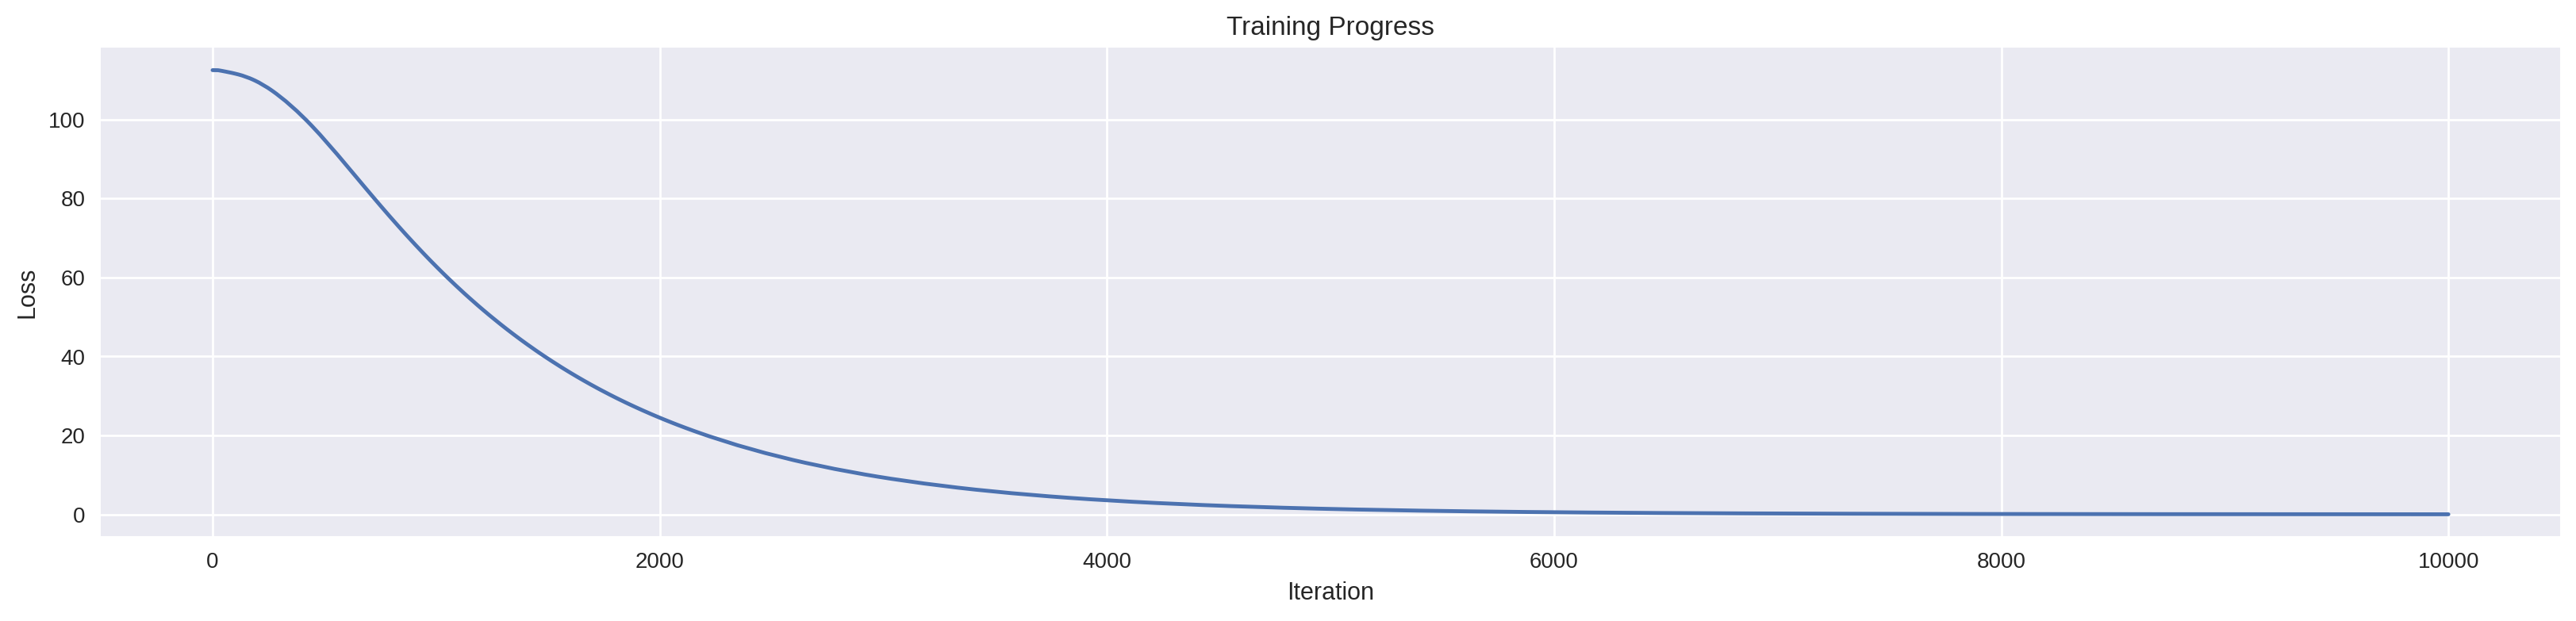

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [18]:
seed_words = ['the', 'and', 'he', 'was', 'i']
for word in seed_words:
    generated = sample(word, n_words=50)
    print(word, ':', generated)
    print("-" * 60)

the : the up small pebbles by water started picking up small pebbles one by one upon upon a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying for a
------------------------------------------------------------
and : and upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying for a long time , the crow finally saw a pitcher lying
------------------------------------------------------------
he : he up small pebbles into into the water began to rise . the crow continued dropping stones until the water came a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak
------------------------------------------------------------
was : was small water pitcher one and the pitcher . slowly , the water b

In [19]:
# Test with SOS token (no seed word)
for i in range(3):
    generated = sample(seed_word=None, n_words=30, use_sos=True, stop_at_eos=True)
    print(f"Sample {i+1}: {generated}")
    print("-" * 60)

Sample 1: by upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor
------------------------------------------------------------
Sample 2: it upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor
------------------------------------------------------------
Sample 3: crow up small pebbles one upon the water came feeling tired and weak . after flying for a long time , the crow finally saw a pitcher lying under a
------------------------------------------------------------


In [20]:
# Test with unknown word
generated = sample('elephant', n_words=30, stop_at_eos=True)
print(f"elephant: {generated}")
print("=" * 60)

elephant: <UNK> at he up small pebbles by into into the pitcher . slowly , the water began to rise . the crow continued dropping stones until the water came a very


## **SUMMARY**


### **Further Reading:**
1. [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) — Olah (2015) - Visual explanations (covers GRU too)
2. [Empirical Evaluation of Gated RNNs](https://arxiv.org/abs/1412.3555) — Chung et al. (2014) - GRU vs LSTM comparison
3. [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) — Karpathy (2015) - Character-level modeling
4. [Attention Is All You Need](https://arxiv.org/abs/1706.03762) — Vaswani et al. (2017) - Transformers replacing RNNs
5. Deep Learning Book, Chapter 10 — Goodfellow et al. (2016) - Comprehensive RNN theory
6. [GRU vs LSTM: A Comparison](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) — Practical guide with visualizations
